In [1]:
import os
import torch
import numpy as np
from tqdm import tqdm
from PIL import Image

from denoisingheat.models.ddpm.denoising_diffusion import Unet
from denoisingheat.models.heat.heat_diffusion import HeatDiffusion_Revised
from denoisingheat.utils.utils import (
    overlay_goal, gen_agents, draw_obstacles_pil, convert_to_obstacle_masks, 
    draw_obstacles_pixel,clear_img, clear_obs, load_config
)
from denoisingheat.utils.diffusion_utils import bilinear_interpolate_samples

import matplotlib.pyplot as plt
from typing import Optional


# Args
config_dir = "./denoisingheat/configs/heat_diffusion.yaml"
args = load_config(config_dir)
device = args['device']

bg = Image.open('assets/toy_exp/background0.png')
bg2 = Image.open('assets/toy_exp/background0.png')
wastes = []
wastes.append(Image.open('assets/toy_exp/waste0.png'))
# wastes.append(Image.open('assets/toy_exp/waste4.png'))
# wastes.append(Image.open('assets/toy_exp/waste5.png'))


img_size = args['image_size']
goal_bounds = args['goal_bounds']
goal_num = len(wastes)
agent_bounds = args['agent_bounds']
obstacle_pos = args['obstacles']

model_path = os.path.join(args['log_path'], args['model_path'])

u0 = args['u0']
min_heat_step = args['min_heat_step']
max_heat_step = args['max_heat_step']
noise_steps = args['noise_steps']
sample_num = args['sample_num']
time_type = args['time_type']

train_lr = args['train_lr']
batch_size = noise_steps # args['batch_size']


c:\Users\User\anaconda3\envs\dnheat\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Inference Setups - Model & Heat-inspired diffusion kernel

In [2]:
class Unet2D(Unet):
    def __init__(
        self, 
        dim, 
        out_dim, 
        dim_mults=(1, 2, 4, 8),
    ):
        super().__init__(dim=dim, out_dim=out_dim, dim_mults=dim_mults)

    def forward(self, obs, t, x_t:Optional[torch.Tensor]=None):
        score_field = super().forward(obs, t)
        if x_t is not None:
            score = bilinear_interpolate_samples(score_field, x_t)    # output: (B,2)
            return score, score_field.permute(0,2,3,1)
        else:
            return score_field.permute(0, 2, 3, 1)
    
model = Unet2D(
    dim=img_size,
    out_dim = 2,
    dim_mults = (1, 2, 4, 8),
).to(device)

diffusion = HeatDiffusion_Revised(
    image_size=img_size,
    u0 = u0,
    noise_steps=noise_steps,
    min_heat_step=min_heat_step,
    max_heat_step=max_heat_step,
    time_type=time_type,
    device=device,
)

model.load_state_dict(torch.load(f'./runs/heat/model_params.pt'))

# Function to identify agents involved in collisions
def collision_mask(states, obstacle):
    """
        states: [B, N ,2]
        obstacle: [B, img_sz, img_sz]
    """
    mapped_states = ((states + 1)*31.5).long()
    
    overlap_mask = []
    for b in range(states.size(0)):
        batch_overlap = [obstacle[b, y, x] for y, x in mapped_states[b]]
        overlap_mask.append(batch_overlap)
    collision_mask_tensor = torch.tensor(overlap_mask, dtype=torch.bool)

    return collision_mask_tensor

dt:tensor([   50,   162,   338,   722,  1352,  2450,  4418,  7442, 12168, 20000],
       device='cuda:0')
heat kernel std:tensor([ 5.,  9., 13., 19., 26., 32., 32., 32., 32., 32.], device='cuda:0')


#### Generate a map with either pre-set or randomly placed obstacles

You can visualize the generated map with plt.imshow

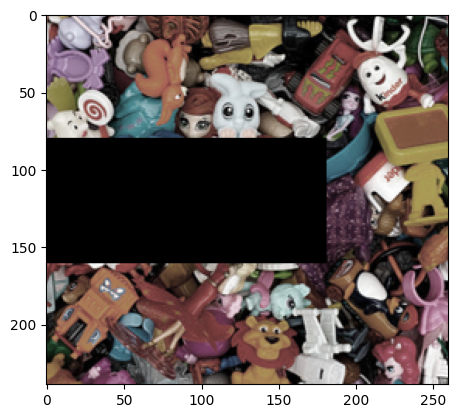

In [3]:
# Pre-set map
background = draw_obstacles_pil(bg, obstacle_pos)
background1 = draw_obstacles_pil(bg2, obstacle_pos)
obstacle_mask = convert_to_obstacle_masks(noise_steps, background[0].size, img_size, obstacle_pos)

## Random map
# seed = 765
# obstacle_mask = randgen_obstacle_masks(1, img_size, seed=seed) 
# obstacle_mask = convert_to_obstacle_masks(noise_steps, bg.size, img_size, [[0,0,100,80],[180,80,260,160],[0,160,100,250]])
# background = draw_obstacles_pixel(bg, obstacle_mask)
# background1 = draw_obstacles_pixel(bg, obstacle_mask)

# Visualize
plt.imshow(background[0])
plt.show()

obstacle_masks = obstacle_mask[0].unsqueeze(0)

### Generate additional obstacle for unreachable goal

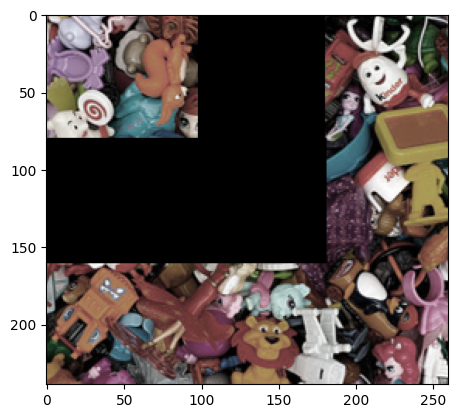

In [4]:
# Generate additional obstacle manually
obstacle_added = convert_to_obstacle_masks(1, background[0].size, img_size, [[100,0,180,100]]) # Able to add more obstacles with additional sublist
background2 = draw_obstacles_pixel(background[0].copy(), obstacle_added)
plt.imshow(background2[0])
plt.show()

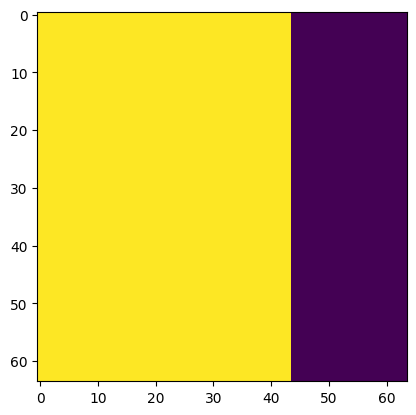

In [5]:
# Create a designated space for generating agents, ensuring they are not placed within unreachable areas. 
## This masking process will not alter the map
obstacle_added2 = convert_to_obstacle_masks(1, background2[0].size, img_size, [[0,0,180,260]])
plt.imshow(obstacle_added2[0].cpu().numpy())
plt.show()

## Inference
1. Manually select goal locations based on the configuration of the created map.
2. To view the results, utilize 'plt.imshow' as demonstrated at the end.

10it [00:52,  5.24s/it]


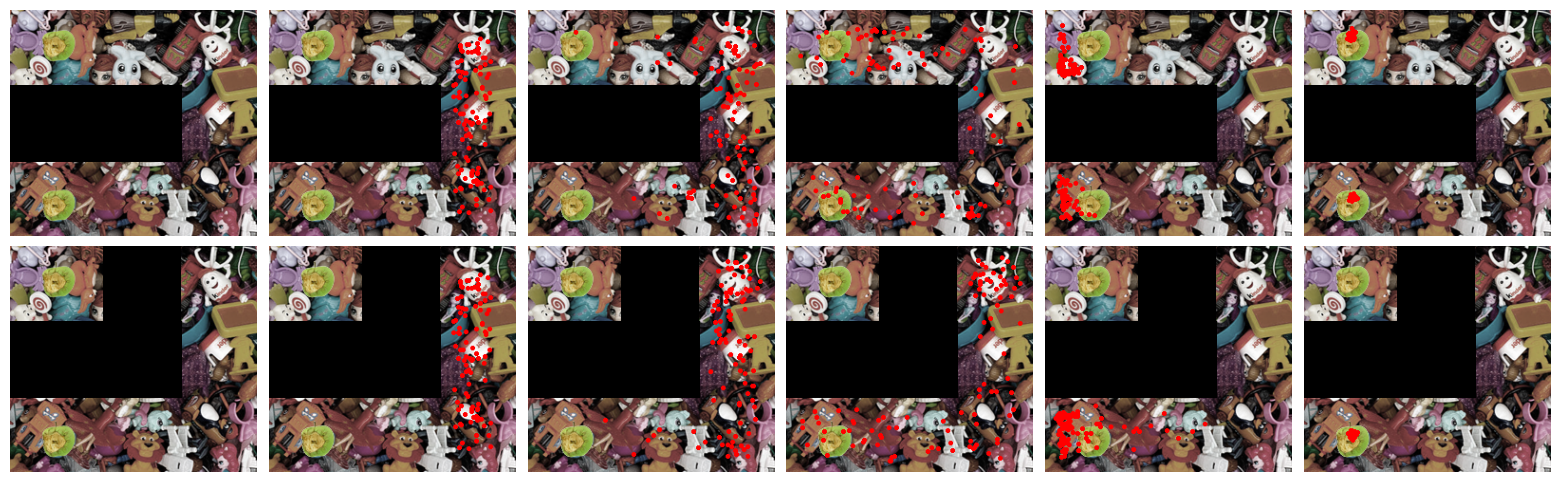

In [6]:
initial_states = 100 # Numbers of agents generated

anneal_it = 100
epsilon = .0008
k1 = .6
k2 = .4

goals2 = torch.tensor([[[-0.7,-0.6],[0.7,-0.6]]], device=device, dtype=torch.float32) # manually select goal locations
obs_T = overlay_goal([background[0].copy()], img_size, wastes, goals2)
obs_T2 = overlay_goal([background2[0].copy()], img_size, wastes, goals2)

c = 10

T = diffusion.noise_steps
step_size = 2
dot_size = 1.

fig, axs = plt.subplots(2, c//step_size+1, figsize=(20,6))  # three rows: (14,5)

model.eval()
ims = []
ims2 = []

backg = background.copy()
backg2 = background2.copy()

axs[0,0].axis('off')
axs[0,0].imshow(clear_obs(goals2.cpu(), backg[0])[0])
axs[1,0].axis('off')
axs[1,0].imshow(clear_obs(goals2.cpu(), backg2[0])[0])

sd = 0

for ex in range(1):
    sd = sd + 1
    with torch.no_grad():
        x_T = gen_agents(goal_bounds, (initial_states,1), img_size, obstacles=obstacle_masks|obstacle_added2, seed=sd) # Generate agents
        x = x_T.clone()
        x2 = x_T.clone()

        k=1
        for i in tqdm(reversed(range(1, T+1)), position=0):
            if i == T or i==int(T*0.7) or i==int(T*0.5) or i==int(T*0.3):
                backg = background[0].copy()
                backg2 = background2[0].copy()
                img_sample = clear_img(x.cpu(), goals2.cpu(), backg)
                img_sample2 = clear_img(x2.cpu(), goals2.cpu(), backg2)

                for s in range(len(img_sample)):
                    axs[0,k].imshow(img_sample[s])
                    axs[0,k].axis('off')
                    axs[1,k].imshow(img_sample2[s])
                    axs[1,k].axis('off')
                    k += 1

            t = (torch.ones(1) * i).long().to(device)

            alpha = epsilon * (diffusion.std[i-1] / diffusion.std[-1])**2

            collision_masks = ~collision_mask(x, obstacle_masks)
            for _ in range(anneal_it):
                x_prev = x.clone()
                score, _ = model(obs_T, t, x)

                x[collision_masks,:] = x_prev[collision_masks,:] + (img_size / (2*diffusion.std[i-1])) * score[collision_masks,:] * alpha**k1 + torch.randn_like(x)[collision_masks,:] * alpha**((k1+k2)/2)

                if not (x[...,:].abs() <=0.99).all():        
                    x = x_prev
                bkg = background[0].copy()
                im = clear_img(x.cpu(), goals2.cpu(), bkg)
                ims.append(im)

            collision_masks2 = ~collision_mask(x2, obstacle_masks|obstacle_added)
            for _ in range(anneal_it):
                x_prev2 = x2.clone()
                score2, _ = model(obs_T2, t, x2)

                x2[collision_masks2,:] = x_prev2[collision_masks2,:] + (img_size / (2*diffusion.std[i-1])) * score2[collision_masks2,:] * alpha**k1 + torch.randn_like(x2)[collision_masks2,:] * alpha**((k1+k2)/2)

                if not (x2[...,:].abs() <=0.99).all():        
                    x2 = x_prev2

                bkg2 = background2[0].copy()
                im2 = clear_img(x2.cpu(),goals2.cpu(), bkg2)
                ims2.append(im2)

        backg = background[0].copy()
        backg2 = background2[0].copy()
        img_sample = clear_img(x.cpu(), goals2.cpu(), backg)
        img_sample2 = clear_img(x2.cpu(), goals2.cpu(), backg2)

        for s in range(len(img_sample)):
            axs[0,-1].imshow(img_sample[s])
            axs[0,-1].axis('off')
            axs[1,-1].imshow(img_sample2[s])
            axs[1,-1].axis('off')


fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.04)
plt.show()